# Z3 SAT Constraints Encodings

In this notebook we are going to show several implementation in z3 of the cardinality constraints and show how they affect the efficiency of the solver. 

In [34]:
from itertools import combinations
from z3 import *
from utils import *
import math

## At most one encodings

### Naive pairwise

In [57]:
def at_least_one_np(bool_vars):
    return Or(bool_vars)

def at_most_one_np(bool_vars):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one_np(bool_vars):
    return And(at_least_one_np(bool_vars), And(at_most_one_np(bool_vars)))

### Sequential 

In [132]:
def at_least_one_seq(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_seq(bool_vars):
    constraints = []
    n = len(bool_vars)
    s = [Bool(f"s_{i}") for i in range(n)]
    starting_constraint = Or(Not(bool_vars[0]), s[0])
    ending_constraint = Or(Not(bool_vars[-1]), Not(s[n-2]))
    for i in range(1, n-1):
        constraints.append(Or(Not(bool_vars[i]), s[i]))
        constraints.append(Or(Not(bool_vars[i]), s[i-1]))
        constraints.append(Or(Not(s[i-1]), s[i]))
    return And(And(constraints), starting_constraint, ending_constraint)

def exactly_one_seq(bool_vars):
    return And(at_least_one_seq(bool_vars), at_most_one_seq(bool_vars))

### Bitwise

In [124]:
def at_least_one_bw(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_bw(bool_vars):
    constraints = []
    n = len(bool_vars)
    m = int(math.log2(n - 1))
    r = [Bool(f"r_{i}") for i in range(m)]
    for i in range(n):
        local_constraints = []
        for j in range(m):
            i_binary = bin(i).split("b")[-1]
            if len(i_binary) < 2 * m:
                i_binary = "0"*((2*m) - len(i_binary)) + i_binary
            for k in i_binary:
                if k == "1": 
                    local_constraints.append(Or(Not(bool_vars[i]), r[j]))
                else:
                    local_constraints.append(Or(Not(bool_vars[i]), Not(r[j])))
        constraints.append(And(local_constraints))
    return And(constraints)

def exactly_one_bw(bool_vars):
    return And(at_least_one_bw(bool_vars), at_most_one_bw(bool_vars)) 

### Heule 

In [87]:
def at_least_one_he(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_he(bool_vars):
    if len(bool_vars) <= 4:
        return And(at_most_one_np(bool_vars))
    y = Bool("y")
    print(bool_vars[:3] + [y])
    print(bool_vars[3:] + [Not(y)])
    return And(at_most_one_np(bool_vars[:3] + [y]), at_most_one_np(bool_vars[3:] + [Not(y)]))

def exactly_one_he(bool_vars):
    return And(at_most_one_he(bool_vars), at_least_one_he(bool_vars))

## Examples

### N-queens

In [119]:
def nqueens_sat(n):
    # Create all the variables
    p = [[Bool(f"x_{i}_{j}") for j in range(n)] for i in range(n)]

    # Create the solver instance
    s = Solver()

    # At least one on each row and column
    for i in range(n):
        s.add(at_least_one(p[i]))
        s.add(at_least_one([p[j][i] for j in range(n)]))

    # At most one on each row and column
    for i in range(n):
        col_i = []
        for j in range(n):
            col_i += [p[j][i]]
        s.add(at_most_one(p[i]))
        s.add(at_most_one(col_i))

    # Add the diagonal constraints
    for i in range(n - 1):
        diag_ru = []
        diag_lu = []
        diag_rl = []
        diag_ll = []
        for j in range(n - i):
            diag_ru += [p[i + j][j]]
            diag_lu += [p[n - 1 - (i + j)][j]]
            diag_rl += [p[i + j][n - 1 - j]]
            diag_ll += [p[n - 1 - (i + j)][n - 1 - j]]
        s.add(at_most_one(diag_ru))
        s.add(at_most_one(diag_lu))
        s.add(at_most_one(diag_rl))
        s.add(at_most_one(diag_ll))

    s.check()

    m = s.model()
    return [(i, j) for i in range(n) for j in range(n) if m.evaluate(p[i][j])]

In [121]:
%%time
at_most_one = at_most_one_np
at_least_one = at_least_one_np 
exactly_one = exactly_one_np
display_nqueens(nqueens_sat(40))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . 
. . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . 
. . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. ♛ . . . . . . . . . . . . 

In [133]:
%%time
at_most_one = at_most_one_seq
at_least_one = at_least_one_seq
exactly_one = exactly_one_seq
display_nqueens(nqueens_sat(8))

Z3Exception: model is not available

In [127]:
%%time
at_most_one = at_most_one_bw
at_least_one = at_least_one_bw
exactly_one = exactly_one_bw
display_nqueens(nqueens_sat(8))

Z3Exception: model is not available

In [129]:
%%time
at_most_one = at_most_one_he
at_least_one = at_least_one_he
exactly_one = exactly_one_he
display_nqueens(nqueens_sat(8))

[x_0_0, x_0_1, x_0_2, y]
[x_0_3, x_0_4, x_0_5, x_0_6, x_0_7, Not(y)]


Z3Exception: Python bool, int, long or float expected

### Coloring graph

In [134]:
def coloring_graph_sat(n, d, E):
    print(exactly_one)
    # Create the variables, x_i_j = 1 iff vertex i is colored with color j.
    v = [[Bool(f"x_{i}_{j}") for j in range(d)] for i in range(n)]
    
    # Solver instance
    s = Solver()
    
    # Each vertex has one color 
    for i in range(n):
        s.add(exactly_one(v[i]))
    
    # Each edge must have different colors in its vertices
    for i, j in E:
        for k in range(d):
            s.add(Or(Not(v[i][k]), Not(v[j][k])))
    
    s.check()
    m = s.model()
    
    return [(i, j) for i in range(n) for j in range(d) if m.evaluate(v[i][j])]    

In [135]:
instance1 = {
        "n" : 5,
        "d": 3,
        "E" : [
            (0, 2),
            (0, 4),
            (1, 2),
            (1, 4),
            (2, 3), 
            (3, 4)
        ]
    }
instance2 = {
        "n":10,
        "d":3,
        "E":[
            (0, 1),
            (0, 4),
            (0, 5),
            (1, 2),
            (1, 6),
            (2, 7),
            (2, 3),
            (3, 8),
            (3, 4),
            (4, 9),
            (9, 6),
            (9, 7),
            (6, 8),
            (5, 7),
            (5, 8), 
        ]
}
instance3 = {
        "n":15,
        "d":5,
        "E":[
            (0, 1),
            (0, 4),
            (0, 5),
            (1, 2),
            (1, 6),
            (2, 7),
            (2, 3),
            (3, 8),
            (3, 4),
            (4, 9),
            (9, 6),
            (9, 7),
            (6, 8),
            (5, 7),
            (5, 8), 
        ]
}

In [136]:
instance = instance2

<function exactly_one_np at 0x7feca69b60d0>
CPU times: user 162 ms, sys: 4.75 ms, total: 167 ms
Wall time: 183 ms


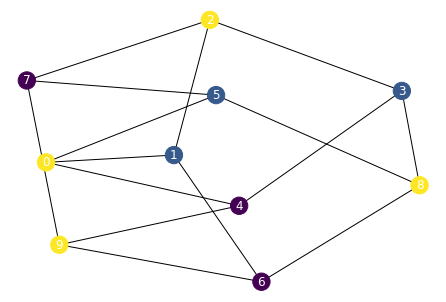

In [97]:
%%time
at_most_one = at_most_one_np
at_least_one = at_least_one_np 
exactly_one = exactly_one_np
display_color_graph(sol = coloring_graph_sat(instance["n"], instance["d"], instance["E"]), E = instance["E"])

In [137]:
%%time
at_most_one = at_most_one_seq
at_least_one = at_least_one_seq 
exactly_one = exactly_one_seq
display_color_graph(sol = coloring_graph_sat(instance["n"], instance["d"], instance["E"]), E = instance["E"])

<function exactly_one_seq at 0x7feca7f39a60>


Z3Exception: model is not available

In [117]:
%%time
at_most_one = at_most_one_bw
at_least_one = at_least_one_bw
exactly_one = exactly_one_bw
instance = instance2
display_color_graph(sol = coloring_graph_sat(instance["n"], instance["d"], instance["E"]), E = instance["E"])

<function exactly_one_bw at 0x7feca81c4310>
[x_0_0, x_0_1, x_0_2]
[And(Or(Not(x_0_0), Not(r_0)), Or(Not(x_0_0), Not(r_0))), And(Or(Not(x_0_1), Not(r_0)), Or(Not(x_0_1), r_0)), And(Or(Not(x_0_2), r_0), Or(Not(x_0_2), Not(r_0)))]
[x_1_0, x_1_1, x_1_2]
[And(Or(Not(x_1_0), Not(r_0)), Or(Not(x_1_0), Not(r_0))), And(Or(Not(x_1_1), Not(r_0)), Or(Not(x_1_1), r_0)), And(Or(Not(x_1_2), r_0), Or(Not(x_1_2), Not(r_0)))]
[x_2_0, x_2_1, x_2_2]
[And(Or(Not(x_2_0), Not(r_0)), Or(Not(x_2_0), Not(r_0))), And(Or(Not(x_2_1), Not(r_0)), Or(Not(x_2_1), r_0)), And(Or(Not(x_2_2), r_0), Or(Not(x_2_2), Not(r_0)))]
[x_3_0, x_3_1, x_3_2]
[And(Or(Not(x_3_0), Not(r_0)), Or(Not(x_3_0), Not(r_0))), And(Or(Not(x_3_1), Not(r_0)), Or(Not(x_3_1), r_0)), And(Or(Not(x_3_2), r_0), Or(Not(x_3_2), Not(r_0)))]
[x_4_0, x_4_1, x_4_2]
[And(Or(Not(x_4_0), Not(r_0)), Or(Not(x_4_0), Not(r_0))), And(Or(Not(x_4_1), Not(r_0)), Or(Not(x_4_1), r_0)), And(Or(Not(x_4_2), r_0), Or(Not(x_4_2), Not(r_0)))]
[x_5_0, x_5_1, x_5_2]
[And(Or(Not(x_

Z3Exception: model is not available

<function exactly_one_he at 0x7feca7ee20d0>
CPU times: user 91.5 ms, sys: 6.07 ms, total: 97.6 ms
Wall time: 109 ms


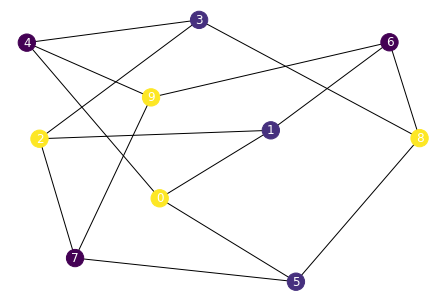

In [118]:
%%time
at_most_one = at_most_one_he
at_least_one = at_least_one_he
exactly_one = exactly_one_he
display_color_graph(sol = coloring_graph_sat(instance["n"], instance["d"], instance["E"]), E = instance["E"])

## At most k encodings

### Naive pairwise

In [13]:
def at_least_k_np(bool_vars, k):
    return at_most_k_np([Not(var) for var in bool_vars], len(bool_vars)-k)

def at_most_k_np(bool_vars, k):
    constraints = []
    for i in range(k):
        constraints+=[And([Not(var) if var not in pair else var for var in bool_vars]) for pair in combinations(bool_vars, i + 1)]  
    return Or(constraints)

def exactly_k_np(bool_vars, k):
    return [at_most_k_np(bool_vars, k)] + [at_least_k_np(bool_vars, k)]

### Sequential

In [ ]:
def at_least_k_seq(bool_vars, k):
    return at_most_k_seq([Not(var) for var in bool_vars], k)

def at_most_k_seq(bool_vars, k):
    constraints = []
    n = len(bool_vars)
    s = [Bool(f"s_{i}_{j}") for i in range(n) for j in range(k)]
    constraints.append(Or(Not(bool_vars[0]), s[0][0]))
    constraints += [Not(s[0][j]) for j in range(1, k)]
    for i in range(1, n-1):
        constraints.append(Or(Not(bool_vars[i]), s[i][0]))
        constraints.append(Or(Not(s[i-1][0]), s[i][0]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i-1][-1])))
        for j in range(1, k):
            constraints.append(Or([Not(bool_vars[i])] + [(Not(s[i-1][j-1]))] + [s[i][j]]))
            constraints.append(Or(Not(s[i-1][j]), s[i][j]))
    constraints.append(Or(Not(bool_vars[-1]), Not(s[-1][-1])))   
    return constraints

def exactly_k_seq(bool_vars, k):
    return at_most_k_seq(bool_vars, k) + at_least_k_seq(bool_vars, k)

## Examples